In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

This project is aimed at determining when the same bus routes going in the same direction arrives at the same stop within a short period of time. This is also known as bus bunching. The data used in this project is from [here](https://mbta-massdot.opendata.arcgis.com/datasets/b7b36fdb7b3a4728af2fccc78c2ca5b7/about). This data only has certain time points, i.e. not every bus stop.

# Cleaning the data

First, let's deal with missing data and formatting of the data


In [2]:
df = pd.concat([pd.read_csv(os.path.join('data', file)) for file in os.listdir('data')])

In [3]:
# check for missing data
df.isnull().sum()

service_date                0
route_id                    0
direction_id                0
half_trip_id             1405
stop_id                     0
time_point_id               0
time_point_order            0
point_type                  0
standard_type               0
scheduled                   0
actual                2234140
scheduled_headway    14323783
headway              16931772
dtype: int64

In [4]:
# drop columns to reduce memory usage
df = df.drop(columns=['scheduled_headway', 'headway', 'time_point_id'], axis=1)

In [5]:
# reformat some columns to reduce memory usage
df.loc[:, 'inbound'] = (df['direction_id'] == 'Inbound')
df = df.drop(columns=['direction_id'], axis=1)

df.loc[:, 'headway_standard'] = (df['standard_type'] == 'Headway')
df = df.drop(columns=['standard_type'], axis=1)

In [6]:
# pinpoint that all instances of half_trip_id being null are endpoints,
# so we can drop the rows with missing half_trip_id
df[df['half_trip_id'].isnull()]['point_type'].unique()

array(['Endpoint'], dtype=object)

In [ ]:
# drop entries with missing data
df = df.dropna(subset=['half_trip_id', 'actual'])

# reformat time columns
for col in ['service_date', 'scheduled', 'actual']:
    df[col] = pd.to_datetime(df.loc[:,col])

# we don't need point_type anymore
df = df.drop(columns=['point_type'], axis=1)

Next, let's calculate the time differences of interest, such as the time between buses and the time between stops.

In [8]:
# focus on each stop, grouping together a specific route and direction at that stop
# this is also sorted by actual arrival time
df = df.sort_values('actual')
df_by_stop = df.groupby(['service_date', 'route_id', 'inbound', 'stop_id'])

In [9]:
# get log of the time difference between two consecutive buses 
# on the same route and direction at a certain stop, 
df['diff_at_stop'] = df_by_stop['actual'].diff().apply(lambda x: np.log1p(x.seconds))

In [10]:
# group together a vehicle's half trip, sorted by actual stop times
df = df.sort_values('actual')
df_by_vehicle = df.groupby(['half_trip_id'])

In [11]:
# get times between buses for the 3 previous timepoints
for i in range(1,4):
    for col in ['diff_at_stop', 'actual', 'scheduled']:
        df[f'{col}_shift{i}'] = df_by_vehicle.shift(i)[col]

In [12]:
# get log of actual and scheduled times between current stop and each of the 3 previous timepoints
for i in range(1,4):
    for col in ['actual', 'scheduled']:
        df[f'veh_{col}_diff{i}'] = (df[col] - df[f'{col}_shift{i}']).apply(lambda x: np.log1p(x.seconds))

df = df.drop(columns=['actual_shift1', 'actual_shift2', 'actual_shift3',
                      'scheduled_shift1', 'scheduled_shift2', 'scheduled_shift3'], axis=1)

In [13]:
# dropping entries with insufficient information
df = df.dropna(subset=['diff_at_stop', 'diff_at_stop_shift1', 'diff_at_stop_shift2', 
                       'diff_at_stop_shift3', 'veh_actual_diff2', 
                       'veh_scheduled_diff3', 'veh_scheduled_diff1'])

Since I'm interested in looking at when the same bus routes arrive too closely at a particular bus stop, I'll need a criterion for when the buses are bunched. I'll say that a bus is "bunched" if it arrives within 60 seconds of the previous bus at that stop. 

In [14]:
# mark instances where the same bus in the same direction appears at the same bus stop
# within 60 seconds to be "bunched"
k = np.log1p(60)
df.loc[:,'bunched'] = (df['diff_at_stop'] <= k)

In [4]:
# turn the bus arrival times into seconds from midnight
df.loc[:,'actual'] = df['actual'].apply(lambda x:3600*x.hour + 60*x.minute + x.second)

In [ ]:
# if saving dataframe as csv

# df.to_csv('df.csv')

In [3]:
# if loading dataframe from a csv

df = pd.read_csv('df.csv')
# reformat time columns
for col in ['service_date', 'scheduled', 'actual']:
    df[col] = pd.to_datetime(df.loc[:,col])


# Splitting the data into training/validation/test

I want to split the data into training, validation, and test sets. This split will be time-based. The first 8 months goes to the training set. The next 2 months are the validation set, and the last 2 months are the test set. 

In [5]:
months = df['service_date'].apply(lambda x:x.month)

In [6]:
df_train = df[months <= 8]
df_valid = df[(months == 9) | (months == 10)]
df_test = df[months >= 11]

In [7]:
X_train = df_train.drop('bunched', axis=1)
y_train = df_train['bunched']

X_val = df_valid.drop('bunched', axis=1)
y_val = df_valid['bunched']

X_test = df_test.drop('bunched', axis=1)
y_test = df_test['bunched']

# Data exploration

Let's first explore the distribution of some of the variables. 

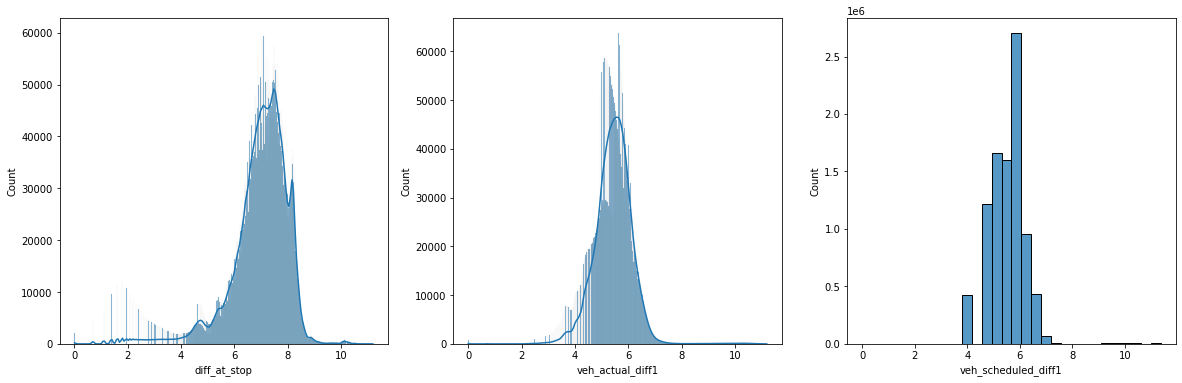

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))
sns.histplot(kde=True, data=X_train['diff_at_stop'], ax=axs[0])
sns.histplot(kde=True, data=X_train['veh_actual_diff1'], ax=axs[1])
sns.histplot(bins=30, data=X_train['veh_scheduled_diff1'], ax=axs[2])
plt.show()

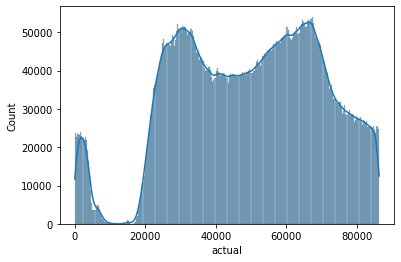

In [49]:
sns.histplot(kde=True, data=X_train['actual'])
plt.show()

The distribution of all these variables look fairly normal. Let's try to look at the correlation between the numerical features.

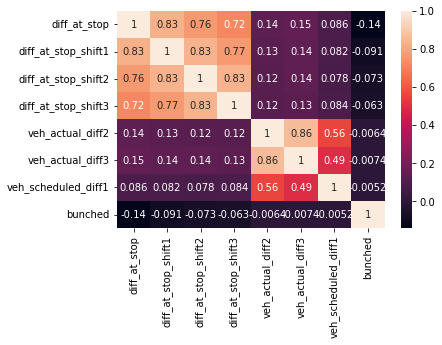

In [20]:
sns.heatmap(X_train[['diff_at_stop', 'diff_at_stop_shift1', 'diff_at_stop_shift2', 
                       'diff_at_stop_shift3', 'veh_actual_diff2', 
                       'veh_actual_diff3', 'veh_scheduled_diff1']].join(y_train).corr(),
            annot=True)
plt.show()

The time between the same bus routes at a particular stop is fairly strongly correlated with the time between the same bus routes at previous stops, with the correlation getting weaker the more stops we look into the past.

However, it looks like the time between the stops (veh_actual_diff2, veh_actual_diff3, veh_scheduled_diff1) have no linear relationship with the time between buses of the same route at a particular stop. 

Let's also see if the time of day makes it more likely that buses are bunched or not. 

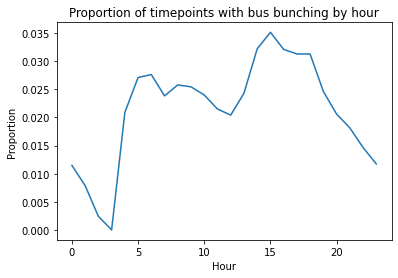

In [59]:
plt.plot(df_train.groupby(df_train['actual'].apply(lambda x:x.hour))['bunched'].mean())
plt.title('Proportion of timepoints with bus bunching by hour')
plt.xlabel('Hour')
plt.ylabel('Proportion')
plt.show()

There are definitely times during the day where bus bunching occurs more often.

Let's also look at whether the standard (schedule/headway) on which the bus is evaluated determines how close consecutive buses are.

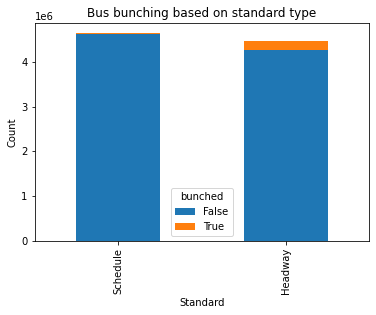

In [86]:
ax = df_train.groupby(['headway_standard', 'bunched']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)
plt.ylabel('Count')
plt.xlabel('Standard')
plt.title('Bus bunching based on standard type')
labs = ax.get_xticklabels()
labs[0].set_text('Schedule')
labs[1].set_text('Headway')
ax.set_xticklabels(labs)
plt.show()

I noticed from this bar plot that being bunched is much more rare than not being bunched, so this is an imbalanced binary classification problem. This means to evaluate models, let's use the PR-AUC metric.

I also notice that buses evaluated on a headway standard are much more likely to be bunched. Let's see if we can see this using the actual times between buses.

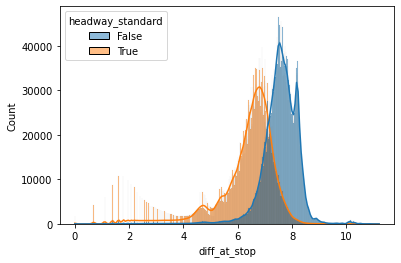

In [87]:
sns.histplot(kde=True, data=X_train, x='diff_at_stop', hue='headway_standard')
plt.show()

Let's also see if the bus route can be an indicator of bus bunching.

In [134]:
bunch_prop_by_route = df_train.groupby('route_id')['bunched'].mean()

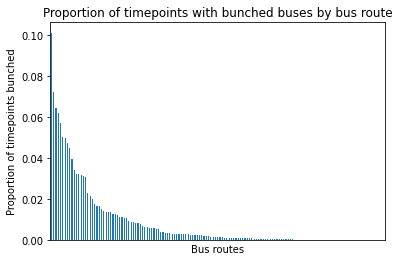

In [150]:
bunch_prop_by_route.sort_values(ascending=False).plot(kind='bar')
plt.xticks([])
plt.xlabel('Bus routes')
plt.ylabel('Proportion of timepoints bunched')
plt.title('Proportion of timepoints with bunched buses by bus route')
plt.show()

It looks like there are some bus routes with a lot more bus bunching than others. 

# Training models

Based off of the data exploration, I want to try training a logistic regression and a gradient boosting using the time information known to a bus before the particular timepoint, the bus route, the standard type, and the time of day as predictors for bus bunching. 

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, average_precision_score

In [57]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['route_id']),
        ('num', StandardScaler(), ['diff_at_stop_shift1', 'diff_at_stop_shift2', 
                'diff_at_stop_shift3', 'veh_actual_diff2', 
                'veh_scheduled_diff3', 'veh_scheduled_diff1', 'actual']),
        ('select', 'passthrough', ['headway_standard'])
    ],
    remainder='drop')

logreg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('logistic_regression', LogisticRegression(
                                random_state=20
                            ))])

In [58]:
logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['route_id']),
                                                 ('num', StandardScaler(),
                                                  ['diff_at_stop_shift1',
                                                   'diff_at_stop_shift2',
                                                   'diff_at_stop_shift3',
                                                   'veh_actual_diff2',
                                                   'veh_scheduled_diff3',
                                                   'veh_scheduled_diff1',
                                                   'actual']),
                                                 ('select', 'passthrough',
                                                  ['headway_standard'])])),
                ('logistic_regression', LogisticRegression(random_state=20))])

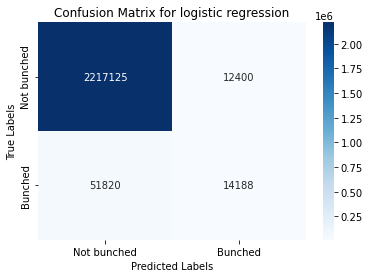

The PR-AUC score for the logistic regression model is 0.3859339464645496.


In [59]:
preds = logreg.predict(X_val)

conf_matrix = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not bunched', 'Bunched'], yticklabels=['Not bunched', 'Bunched'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for logistic regression')
plt.show()

probs = logreg.predict_proba(X_val)[:,1]
pr_auc = average_precision_score(y_val, probs)
print(f'The PR-AUC score for the logistic regression model is {pr_auc}.')

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('select', 'passthrough', 
        ['route_id', 'headway_standard']),
        ('num', StandardScaler(), ['diff_at_stop_shift1', 'diff_at_stop_shift2', 
                'diff_at_stop_shift3', 'veh_actual_diff2', 
                'veh_scheduled_diff3', 'veh_scheduled_diff1', 'actual'])
    ],
    remainder='drop')

gb = Pipeline(steps=[('preprocessor', preprocessor),
                    ('gradient_boost', HistGradientBoostingClassifier(
                        random_state=20,
                        categorical_features=[0],
                        verbose=3,
                    ))])

In [9]:
gb.fit(X_train, y_train)

Binning 0.591 GB of training data: 1.403 s
Binning 0.066 GB of validation data: 0.109 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.08985, val loss: 0.08967, in 0.565s
[2/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.08475, val loss: 0.08455, in 0.659s
[3/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.08110, val loss: 0.08088, in 0.642s
[4/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07829, val loss: 0.07804, in 0.684s
[5/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07603, val loss: 0.07576, in 0.643s
[6/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.07418, val loss: 0.07390, in 0.643s
[7/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07264, val loss: 0.07235, in 0.647s
[8/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.07132, val loss: 0.07102, in 0.664s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07020, val loss: 0.06989, in 0.617s
[10/100] 1 tree, 31 leaves, max depth = 9, train 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('select', 'passthrough',
                                                  ['route_id',
                                                   'headway_standard']),
                                                 ('num', StandardScaler(),
                                                  ['diff_at_stop_shift1',
                                                   'diff_at_stop_shift2',
                                                   'diff_at_stop_shift3',
                                                   'veh_actual_diff2',
                                                   'veh_scheduled_diff3',
                                                   'veh_scheduled_diff1',
                                                   'actual'])])),
                ('gradient_boost',
                 HistGradientBoostingClassifier(categorical_features=[0],
                                                random_state=20, verbose=3))])

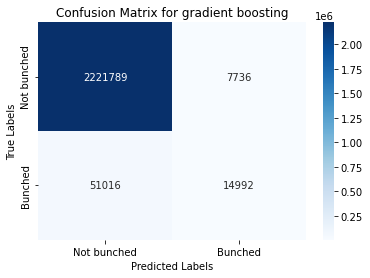

The PR-AUC score for the gradient boosting model is 0.4866894046944841.


In [10]:
preds = gb.predict(X_val)

conf_matrix = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not bunched', 'Bunched'], yticklabels=['Not bunched', 'Bunched'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for gradient boosting')
plt.show()

probs = gb.predict_proba(X_val)[:,1]
pr_auc = average_precision_score(y_val, probs)
print(f'The PR-AUC score for the gradient boosting model is {pr_auc}.')

Next, I want to see if undersampling would help the performance.

In [11]:
from imblearn.under_sampling import RandomUnderSampler

In [12]:
rus = RandomUnderSampler(random_state=20)
X_under, y_under = rus.fit_resample(X_train, y_train)

c:\Users\bliu9\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


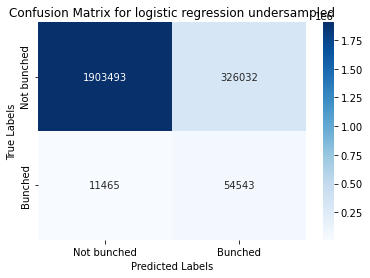

The PR-AUC score for the logistic regression undersampled model is 0.35236781188476346.


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['route_id']),
        ('num', StandardScaler(), ['diff_at_stop_shift1', 'diff_at_stop_shift2', 
                'diff_at_stop_shift3', 'veh_actual_diff2', 
                'veh_scheduled_diff3', 'veh_scheduled_diff1', 'actual']),
        ('select', 'passthrough', ['headway_standard'])
    ],
    remainder='drop')

logreg_under = Pipeline(steps=[('preprocessor', preprocessor),
                            ('logistic_regression', LogisticRegression(
                                random_state=20
                            ))])

logreg_under.fit(X_under, y_under)

preds = logreg_under.predict(X_val)

conf_matrix = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not bunched', 'Bunched'], yticklabels=['Not bunched', 'Bunched'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for logistic regression undersampled')
plt.show()

probs = logreg_under.predict_proba(X_val)[:,1]
pr_auc = average_precision_score(y_val, probs)
print(f'The PR-AUC score for the logistic regression undersampled model is {pr_auc}.')

Binning 0.030 GB of training data: 0.250 s
Binning 0.003 GB of validation data: 0.000 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.63175, val loss: 0.63200, in 0.052s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.58154, val loss: 0.58188, in 0.036s
[3/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.53982, val loss: 0.54034, in 0.031s
[4/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.50485, val loss: 0.50545, in 0.031s
[5/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.47517, val loss: 0.47584, in 0.042s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.44959, val loss: 0.45042, in 0.040s
[7/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.42781, val loss: 0.42873, in 0.034s
[8/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.40897, val loss: 0.40999, in 0.035s
[9/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.39270, val loss: 0.39378, in 0.044s
[10/100] 1 tree, 31 leaves, max depth = 10, tr

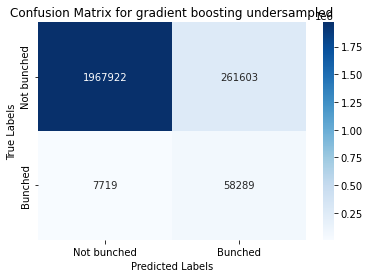

The PR-AUC score for the gradient boosting undersampled model is 0.48542317264109247.


In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ('select', 'passthrough', 
        ['route_id', 'headway_standard']),
        ('num', StandardScaler(), ['diff_at_stop_shift1', 'diff_at_stop_shift2', 
                'diff_at_stop_shift3', 'veh_actual_diff2', 
                'veh_scheduled_diff3', 'veh_scheduled_diff1', 'actual'])
    ],
    remainder='drop')

gb_under = Pipeline(steps=[('preprocessor', preprocessor),
                    ('gradient_boost', HistGradientBoostingClassifier(
                        random_state=20,
                        categorical_features=[0],
                        verbose=3,
                    ))])

gb_under.fit(X_under, y_under)

preds = gb_under.predict(X_val)

conf_matrix = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Not bunched', 'Bunched'], yticklabels=['Not bunched', 'Bunched'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for gradient boosting undersampled')
plt.show()

probs = gb_under.predict_proba(X_val)[:,1]
pr_auc = average_precision_score(y_val, probs)
print(f'The PR-AUC score for the gradient boosting undersampled model is {pr_auc}.')

The gradient boosting models performed better than the logistic regression models. Moreover, while undersampling lowered the PR-AUC scores, we were able to identify much more of the bunched buses correctly. Let's see if we can adjust the undersampling ratio and obtain a gradient boosting model with a better PR-AUC score. 

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('select', 'passthrough', 
        ['route_id', 'headway_standard']),
        ('num', StandardScaler(), ['diff_at_stop_shift1', 'diff_at_stop_shift2', 
                'diff_at_stop_shift3', 'veh_actual_diff2', 
                'veh_scheduled_diff3', 'veh_scheduled_diff1', 'actual'])
    ],
    remainder='drop')

gb_under = Pipeline(steps=[('preprocessor', preprocessor),
                    ('gradient_boost', HistGradientBoostingClassifier(
                        random_state=20,
                        categorical_features=[0]
                    ))])

for rat in np.arange(.1, 1, .1):
    rus = RandomUnderSampler(random_state=20, sampling_strategy=rat)
    X_under, y_under = rus.fit_resample(X_train, y_train)
    gb_under.fit(X_under, y_under)

    preds = gb_under.predict(X_val)
    conf_matrix = confusion_matrix(y_val, preds)

    probs = gb_under.predict_proba(X_val)[:,1]
    pr_auc = average_precision_score(y_val, probs)
    print(f'''The PR-AUC score for the gradient boosting 
          undersampled with ratio {rat:.1f} model is {pr_auc:.4f}
          and the confusion matrix is {conf_matrix}.''')
    

The PR-AUC score for the gradient boosting 
          undersampled with ratio 0.1 model is 0.4886
          and the confusion matrix is [[2172453   57072]
 [  23047   42961]].
The PR-AUC score for the gradient boosting 
          undersampled with ratio 0.2 model is 0.4920
          and the confusion matrix is [[2138338   91187]
 [  16689   49319]].
The PR-AUC score for the gradient boosting 
          undersampled with ratio 0.3 model is 0.4898
          and the confusion matrix is [[2116472  113053]
 [  14426   51582]].
The PR-AUC score for the gradient boosting 
          undersampled with ratio 0.4 model is 0.4896
          and the confusion matrix is [[2095802  133723]
 [  12931   53077]].
The PR-AUC score for the gradient boosting 
          undersampled with ratio 0.5 model is 0.4892
          and the confusion matrix is [[2071200  158325]
 [  11542   54466]].
The PR-AUC score for the gradient boosting 
          undersampled with ratio 0.6 model is 0.4886
          and the conf

The different sampling strategies do not have a large effect on the PR-AUC scores. While a larger undersampling ratio allows us to classify more of the bunched buses, we also get more buses that are not bunched classified as bunched. If there are limited resources on which buses we should take action on to reduce bus bunching, we should classify fewer buses to be bunched since unbunched buses would not need any resources spent on them. For this reason, we will not undersample. 

Now let's try to tune the hyperparamaters of the gradient boosting model. 

In [18]:
# define all the steps to perform on a gradient boosting
# model after the hyperparameters are passed through
def train_gb_model(hgbc: HistGradientBoostingClassifier):    
    preprocessor = ColumnTransformer(
        transformers=[
            ('select', 'passthrough', 
            ['route_id', 'headway_standard']),
            ('num', StandardScaler(), ['diff_at_stop_shift1', 'diff_at_stop_shift2', 
                    'diff_at_stop_shift3', 'veh_actual_diff2', 
                    'veh_scheduled_diff3', 'veh_scheduled_diff1', 'actual'])
        ],
        remainder='drop')

    gb = Pipeline(steps=[('preprocessor', preprocessor),
                        ('gradient_boost', hgbc)])

    gb.fit(X_train, y_train)

    preds = gb.predict(X_val)
    conf_matrix = confusion_matrix(y_val, preds)

    probs = gb.predict_proba(X_val)[:,1]
    pr_auc = average_precision_score(y_val, probs)
    print(f'''The PR-AUC score is {pr_auc:.4f}
        and the confusion matrix is {conf_matrix}.''')

    return gb

In [19]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        learning_rate=0.01
    )
)

Binning 0.591 GB of training data: 1.382 s
Binning 0.066 GB of validation data: 0.098 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.11431, val loss: 0.11429, in 0.595s
[2/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.11180, val loss: 0.11177, in 0.631s
[3/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10965, val loss: 0.10961, in 0.604s
[4/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10777, val loss: 0.10772, in 0.562s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10608, val loss: 0.10602, in 0.572s
[6/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10456, val loss: 0.10449, in 0.568s
[7/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10316, val loss: 0.10309, in 0.554s
[8/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10188, val loss: 0.10180, in 0.577s
[9/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10069, val loss: 0.10060, in 0.614s
[10/100] 1 tree, 31 leaves, max depth = 8, train lo

In [20]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_depth=20,
        max_leaf_nodes=50
    )
)

Binning 0.591 GB of training data: 1.464 s
Binning 0.066 GB of validation data: 0.101 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 50 leaves, max depth = 9, train loss: 0.08957, val loss: 0.08941, in 0.806s
[2/100] 1 tree, 50 leaves, max depth = 10, train loss: 0.08447, val loss: 0.08429, in 0.866s
[3/100] 1 tree, 50 leaves, max depth = 9, train loss: 0.08081, val loss: 0.08061, in 0.769s
[4/100] 1 tree, 50 leaves, max depth = 11, train loss: 0.07799, val loss: 0.07777, in 0.692s
[5/100] 1 tree, 50 leaves, max depth = 10, train loss: 0.07571, val loss: 0.07548, in 0.723s
[6/100] 1 tree, 50 leaves, max depth = 11, train loss: 0.07386, val loss: 0.07361, in 0.678s
[7/100] 1 tree, 50 leaves, max depth = 10, train loss: 0.07230, val loss: 0.07204, in 0.723s
[8/100] 1 tree, 50 leaves, max depth = 11, train loss: 0.07098, val loss: 0.07071, in 0.754s
[9/100] 1 tree, 50 leaves, max depth = 11, train loss: 0.06985, val loss: 0.06958, in 0.707s
[10/100] 1 tree, 50 leaves, max depth = 11, 

In [21]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_depth=20,
        max_leaf_nodes=100
    )
)

Binning 0.591 GB of training data: 1.368 s
Binning 0.066 GB of validation data: 0.101 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 100 leaves, max depth = 10, train loss: 0.08926, val loss: 0.08910, in 0.774s
[2/100] 1 tree, 100 leaves, max depth = 13, train loss: 0.08412, val loss: 0.08395, in 0.841s
[3/100] 1 tree, 100 leaves, max depth = 11, train loss: 0.08044, val loss: 0.08026, in 0.849s
[4/100] 1 tree, 100 leaves, max depth = 11, train loss: 0.07759, val loss: 0.07740, in 0.810s
[5/100] 1 tree, 100 leaves, max depth = 11, train loss: 0.07529, val loss: 0.07509, in 0.845s
[6/100] 1 tree, 100 leaves, max depth = 15, train loss: 0.07341, val loss: 0.07320, in 0.803s
[7/100] 1 tree, 100 leaves, max depth = 13, train loss: 0.07184, val loss: 0.07162, in 0.855s
[8/100] 1 tree, 100 leaves, max depth = 13, train loss: 0.07051, val loss: 0.07028, in 0.924s
[9/100] 1 tree, 100 leaves, max depth = 12, train loss: 0.06937, val loss: 0.06915, in 0.864s
[10/100] 1 tree, 100 leaves, max 

In [22]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        min_samples_leaf=10
    )
)

Binning 0.591 GB of training data: 1.401 s
Binning 0.066 GB of validation data: 0.118 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.08985, val loss: 0.08967, in 0.619s
[2/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.08475, val loss: 0.08455, in 0.736s
[3/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.08110, val loss: 0.08088, in 0.712s
[4/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07829, val loss: 0.07804, in 0.637s
[5/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07603, val loss: 0.07576, in 0.631s
[6/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.07418, val loss: 0.07390, in 0.648s
[7/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07264, val loss: 0.07235, in 0.672s
[8/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.07132, val loss: 0.07102, in 0.632s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.07020, val loss: 0.06989, in 0.609s
[10/100] 1 tree, 31 leaves, max depth = 9, train 

In [23]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        min_samples_leaf=10,
        learning_rate=0.01
    )
)

Binning 0.591 GB of training data: 1.323 s
Binning 0.066 GB of validation data: 0.095 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.11431, val loss: 0.11429, in 0.588s
[2/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.11180, val loss: 0.11177, in 0.609s
[3/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10965, val loss: 0.10961, in 0.577s
[4/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10777, val loss: 0.10772, in 0.585s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10608, val loss: 0.10602, in 0.557s
[6/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10456, val loss: 0.10449, in 0.585s
[7/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10316, val loss: 0.10309, in 0.580s
[8/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10188, val loss: 0.10180, in 0.586s
[9/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10069, val loss: 0.10060, in 0.596s
[10/100] 1 tree, 31 leaves, max depth = 8, train lo

In [24]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_iter=300,
        learning_rate=0.01
    )
)

Binning 0.591 GB of training data: 1.349 s
Binning 0.066 GB of validation data: 0.105 s
Fitting gradient boosted rounds:
[1/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.11431, val loss: 0.11429, in 0.606s
[2/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.11180, val loss: 0.11177, in 0.655s
[3/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.10965, val loss: 0.10961, in 0.587s
[4/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.10777, val loss: 0.10772, in 0.598s
[5/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.10608, val loss: 0.10602, in 0.600s
[6/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.10456, val loss: 0.10449, in 0.557s
[7/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.10316, val loss: 0.10309, in 0.564s
[8/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.10188, val loss: 0.10180, in 0.596s
[9/300] 1 tree, 31 leaves, max depth = 8, train loss: 0.10069, val loss: 0.10060, in 0.569s
[10/300] 1 tree, 31 leaves, max depth = 8, train lo

In [25]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_iter=300,
        max_leaf_nodes=50,
        learning_rate=0.01
    )
)

Binning 0.591 GB of training data: 1.333 s
Binning 0.066 GB of validation data: 0.101 s
Fitting gradient boosted rounds:
[1/300] 1 tree, 50 leaves, max depth = 9, train loss: 0.11427, val loss: 0.11426, in 0.652s
[2/300] 1 tree, 50 leaves, max depth = 8, train loss: 0.11175, val loss: 0.11172, in 0.711s
[3/300] 1 tree, 50 leaves, max depth = 8, train loss: 0.10959, val loss: 0.10955, in 0.651s
[4/300] 1 tree, 50 leaves, max depth = 9, train loss: 0.10769, val loss: 0.10764, in 0.640s
[5/300] 1 tree, 50 leaves, max depth = 8, train loss: 0.10599, val loss: 0.10593, in 0.638s
[6/300] 1 tree, 50 leaves, max depth = 8, train loss: 0.10446, val loss: 0.10439, in 0.633s
[7/300] 1 tree, 50 leaves, max depth = 9, train loss: 0.10306, val loss: 0.10298, in 0.657s
[8/300] 1 tree, 50 leaves, max depth = 9, train loss: 0.10176, val loss: 0.10168, in 0.680s
[9/300] 1 tree, 50 leaves, max depth = 9, train loss: 0.10056, val loss: 0.10048, in 0.662s
[10/300] 1 tree, 50 leaves, max depth = 8, train lo

In [26]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_iter=500,
        max_leaf_nodes=100,
        learning_rate=0.02
    )
)

Binning 0.591 GB of training data: 1.346 s
Binning 0.066 GB of validation data: 0.097 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 100 leaves, max depth = 10, train loss: 0.11115, val loss: 0.11112, in 0.748s
[2/500] 1 tree, 100 leaves, max depth = 12, train loss: 0.10697, val loss: 0.10693, in 0.783s
[3/500] 1 tree, 100 leaves, max depth = 11, train loss: 0.10371, val loss: 0.10365, in 0.795s
[4/500] 1 tree, 100 leaves, max depth = 11, train loss: 0.10101, val loss: 0.10093, in 0.749s
[5/500] 1 tree, 100 leaves, max depth = 11, train loss: 0.09870, val loss: 0.09861, in 0.786s
[6/500] 1 tree, 100 leaves, max depth = 11, train loss: 0.09667, val loss: 0.09657, in 0.775s
[7/500] 1 tree, 100 leaves, max depth = 11, train loss: 0.09487, val loss: 0.09477, in 0.769s
[8/500] 1 tree, 100 leaves, max depth = 11, train loss: 0.09325, val loss: 0.09314, in 0.770s
[9/500] 1 tree, 100 leaves, max depth = 11, train loss: 0.09178, val loss: 0.09166, in 0.779s
[10/500] 1 tree, 100 leaves, max 

In [29]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_iter=200,
        max_leaf_nodes=300,
        learning_rate=0.03
    )
)

Binning 0.591 GB of training data: 1.344 s
Binning 0.066 GB of validation data: 0.105 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 300 leaves, max depth = 16, train loss: 0.10793, val loss: 0.10791, in 0.924s
[2/200] 1 tree, 300 leaves, max depth = 13, train loss: 0.10270, val loss: 0.10269, in 0.979s
[3/200] 1 tree, 300 leaves, max depth = 17, train loss: 0.09882, val loss: 0.09880, in 0.943s
[4/200] 1 tree, 300 leaves, max depth = 15, train loss: 0.09570, val loss: 0.09569, in 0.963s
[5/200] 1 tree, 300 leaves, max depth = 16, train loss: 0.09309, val loss: 0.09308, in 0.972s
[6/200] 1 tree, 300 leaves, max depth = 18, train loss: 0.09085, val loss: 0.09083, in 0.998s
[7/200] 1 tree, 300 leaves, max depth = 15, train loss: 0.08888, val loss: 0.08887, in 1.018s
[8/200] 1 tree, 300 leaves, max depth = 17, train loss: 0.08713, val loss: 0.08712, in 1.081s
[9/200] 1 tree, 300 leaves, max depth = 18, train loss: 0.08556, val loss: 0.08555, in 0.995s
[10/200] 1 tree, 300 leaves, max 

In [30]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_iter=200,
        max_leaf_nodes=1000,
        learning_rate=0.03
    )
)

Binning 0.591 GB of training data: 1.341 s
Binning 0.066 GB of validation data: 0.111 s
Fitting gradient boosted rounds:
[1/200] 1 tree, 1000 leaves, max depth = 20, train loss: 0.10765, val loss: 0.10775, in 1.199s
[2/200] 1 tree, 1000 leaves, max depth = 19, train loss: 0.10231, val loss: 0.10250, in 1.346s
[3/200] 1 tree, 1000 leaves, max depth = 22, train loss: 0.09833, val loss: 0.09859, in 1.347s
[4/200] 1 tree, 1000 leaves, max depth = 22, train loss: 0.09514, val loss: 0.09545, in 1.263s
[5/200] 1 tree, 1000 leaves, max depth = 22, train loss: 0.09246, val loss: 0.09283, in 1.243s
[6/200] 1 tree, 1000 leaves, max depth = 22, train loss: 0.09016, val loss: 0.09057, in 1.261s
[7/200] 1 tree, 1000 leaves, max depth = 22, train loss: 0.08813, val loss: 0.08859, in 1.256s
[8/200] 1 tree, 1000 leaves, max depth = 22, train loss: 0.08633, val loss: 0.08683, in 1.341s
[9/200] 1 tree, 1000 leaves, max depth = 26, train loss: 0.08471, val loss: 0.08524, in 1.256s
[10/200] 1 tree, 1000 le

In [32]:
gb = train_gb_model(
    HistGradientBoostingClassifier(
        random_state=20,
        categorical_features=[0],
        verbose=3,
        max_iter=500,
        max_leaf_nodes=1000,
        learning_rate=0.03,
        l2_regularization=0.1
    )
)

Binning 0.591 GB of training data: 1.234 s
Binning 0.066 GB of validation data: 0.085 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 1000 leaves, max depth = 20, train loss: 0.10773, val loss: 0.10784, in 1.084s
[2/500] 1 tree, 1000 leaves, max depth = 19, train loss: 0.10238, val loss: 0.10257, in 1.129s
[3/500] 1 tree, 1000 leaves, max depth = 20, train loss: 0.09841, val loss: 0.09865, in 1.053s
[4/500] 1 tree, 1000 leaves, max depth = 22, train loss: 0.09521, val loss: 0.09551, in 1.052s
[5/500] 1 tree, 1000 leaves, max depth = 20, train loss: 0.09254, val loss: 0.09289, in 1.140s
[6/500] 1 tree, 1000 leaves, max depth = 21, train loss: 0.09023, val loss: 0.09062, in 1.132s
[7/500] 1 tree, 1000 leaves, max depth = 23, train loss: 0.08821, val loss: 0.08864, in 1.074s
[8/500] 1 tree, 1000 leaves, max depth = 22, train loss: 0.08641, val loss: 0.08687, in 1.185s
[9/500] 1 tree, 1000 leaves, max depth = 21, train loss: 0.08479, val loss: 0.08529, in 1.081s
[10/500] 1 tree, 1000 le

In [44]:
# # if saving model
# from joblib import dump
# dump(gb, 'gb.joblib')

['gb.joblib']

In [8]:
# if loading model
from joblib import load
gb = load('gb.joblib')

# Evaluating the model

Let's look at how good the last model is. We know the PR-AUC score is 0.5160. For a practical usage, we want to know how many timepoints we predict to be bunched depending on the probability threshold. And out of those we predict to be bunched, we want to know how many are actually bunched. We assess this on the validation set first. 

In [10]:
from sklearn.metrics import precision_score

In [11]:
# compute precision and true/false positive counts
probs = gb.predict_proba(X_val)[:,1]
cutoff_points = np.linspace(0, 1, 21)

precisions = []
false_pos_counts = []
true_pos_counts = []

for cutoff in cutoff_points:
    preds = (probs >= cutoff).astype(int)

    if preds.any():
        precision = precision_score(y_val, preds)
    else:
        precision = np.nan
    precisions.append(precision)

    false_pos_counts.append(np.sum(preds & ~y_val))
    true_pos_counts.append(np.sum(preds & y_val))

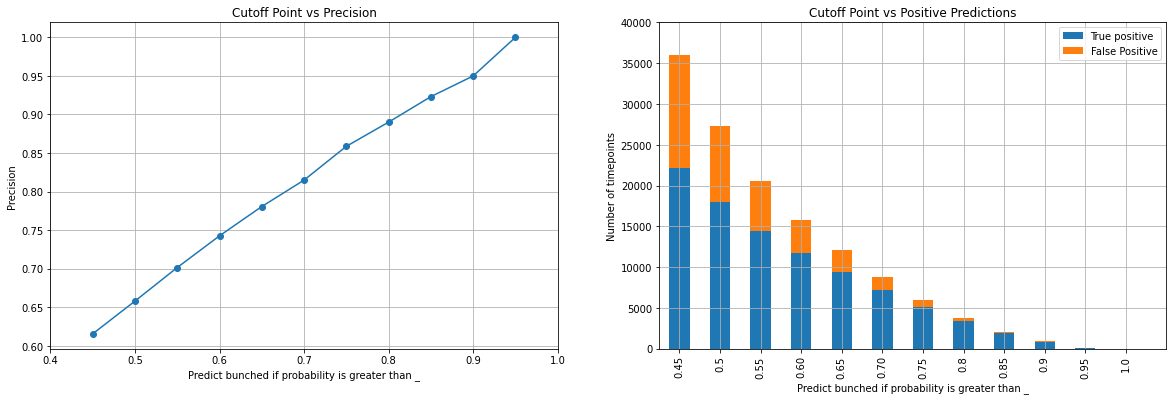

In [105]:
# Plot cutoff point vs precision
fig, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].plot(cutoff_points[-12:], precisions[-12:], marker='o')
axs[0].set_xlabel('Predict bunched if probability is greater than _')
axs[0].set_ylabel('Precision')
axs[0].set_title('Cutoff Point vs Precision')
axs[0].grid(True)
axs[0].set_xlim(0.4, 1)


# Plot cutoff point vs the positive predictions, split into 
# true/false positives.
counts_df = pd.DataFrame({'true_pos': true_pos_counts,
                          'false_pos': false_pos_counts,
                          'cutoff': cutoff_points})

counts_df.plot(kind='bar', x='cutoff', stacked=True, ax=axs[1])
axs[1].set_xlabel('Predict bunched if probability is greater than _')
axs[1].set_ylabel('Number of timepoints')
axs[1].set_title('Cutoff Point vs Positive Predictions')

labs = axs[1].get_xticklabels()
for lab in axs[1].get_xticklabels():
    lab.set_text(lab.get_text()[:4])
axs[1].set_xticklabels(labs)

plt.grid(True)
plt.ylim(0, 40000)
plt.xlim(8.5, 21)
plt.legend(['True positive', 'False Positive'])
plt.show()

For example, if we can afford to act upon 0.2% of all timepoints, which is about 5000 timepoints within the 2 months in the validation set, then we would only consider a timepoint to be bunched if the predicted probability is greater than about 0.8. This will give us a precision of about 89%, meaning out of the timepoints predicted to be bunched, about 89% of them are actually bunched. 

Let's do the same analysis on the test set. 

In [111]:
probs = gb.predict_proba(X_test)[:,1]
pr_auc = average_precision_score(y_test, probs)
print(f'''The PR-AUC score is {pr_auc:.4f}.''')

The PR-AUC score is 0.5242.


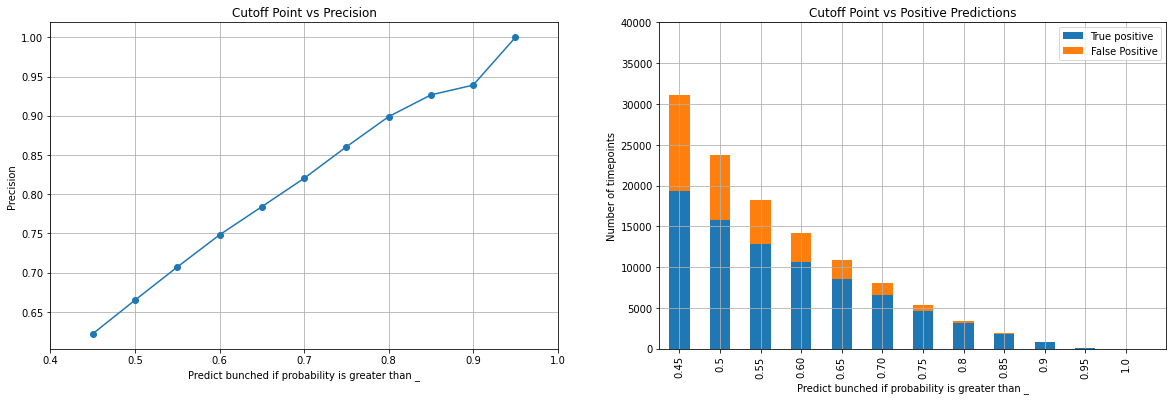

In [112]:
# compute precision and true/false positive counts
cutoff_points = np.linspace(0, 1, 21)

precisions = []
false_pos_counts = []
true_pos_counts = []

for cutoff in cutoff_points:
    preds = (probs >= cutoff).astype(int)

    if preds.any():
        precision = precision_score(y_test, preds)
    else:
        precision = np.nan
    precisions.append(precision)

    false_pos_counts.append(np.sum(preds & ~y_test))
    true_pos_counts.append(np.sum(preds & y_test))

# Plot cutoff point vs precision
fig, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].plot(cutoff_points[-12:], precisions[-12:], marker='o')
axs[0].set_xlabel('Predict bunched if probability is greater than _')
axs[0].set_ylabel('Precision')
axs[0].set_title('Cutoff Point vs Precision')
axs[0].grid(True)
axs[0].set_xlim(0.4, 1)


# Plot cutoff point vs the positive predictions, split into 
# true/false positives.
counts_df = pd.DataFrame({'true_pos': true_pos_counts,
                          'false_pos': false_pos_counts,
                          'cutoff': cutoff_points})

counts_df.plot(kind='bar', x='cutoff', stacked=True, ax=axs[1])
axs[1].set_xlabel('Predict bunched if probability is greater than _')
axs[1].set_ylabel('Number of timepoints')
axs[1].set_title('Cutoff Point vs Positive Predictions')

labs = axs[1].get_xticklabels()
for lab in axs[1].get_xticklabels():
    lab.set_text(lab.get_text()[:4])
axs[1].set_xticklabels(labs)

plt.grid(True)
plt.ylim(0, 40000)
plt.xlim(8.5, 21)
plt.legend(['True positive', 'False Positive'])
plt.show()

We get similar performance as we did on the validation set!